In [0]:
# This performs a basic adversarial attack against the network for
# differentiating malicious from benign flows. This creates adversarial
# examples for the malicious samples in the validaion/testing set 

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
import numpy as np
import tensorflow as tf
import six 
import math
from tensorflow.python.training import moving_averages 
import pickle
import tensorflow.keras.backend as K
from sklearn.preprocessing import normalize
import tensorflow_probability as tfp
CONT_FEATURE_SIZE = 158

In [0]:
## Constants for deciding how to add differential privacy to autoencoder 
NOISE_PLACEMENT = 'img_noise'
NOISE_SCHEME = 'l1_l2'
FILTER_SIZES = 1
NUM_FILTERS = 1 
STRIDES = 1 
L1_MEAN_SIGNAL = 0
L2_MEAN_SIGNAL = 0
L1_NOISE_SIGNAL = 0
L2_NOISE_SIGNAL = 0
EPSILON = 1.0
DELTA_DP = 0.05
SCALE = 1.0
EPOCHS = 40 
NOISE = 0
BATCH_SHAPE = 128
NOISE_TYPE = 'gaussian'
AUTO_ENCODER_OUT_SHAPE = 158
FOLDER = 'USTC2-AutoEncoderGaussian'
NUM_CLASS =2
TRAIN =True 
SCALE_STRING = "1point0"                       

In [0]:
with tf.device('/device:GPU:0'):
  NOISE = img_dp_noise(int(CONT_FEATURE_SIZE/2))
  ## Define the auto encoder without keras 
  x_ = tf.placeholder(tf.float32,shape= [BATCH_SHAPE,CONT_FEATURE_SIZE])
  y_ =tf.placeholder(tf.float32,shape= [BATCH_SHAPE,CONT_FEATURE_SIZE])
  
  x2_ =tf.placeholder(tf.float32,shape= [BATCH_SHAPE,AUTO_ENCODER_OUT_SHAPE])
  y2_ =tf.placeholder(tf.float32,shape= [BATCH_SHAPE,2])
  y3_ =tf.placeholder(tf.float32,shape= [BATCH_SHAPE,10])

In [0]:
def get_logits_cnn(x,return_embedding= False):
  with  tf.variable_scope("tree_second_model",reuse=tf.AUTO_REUSE):
    with  tf.device('/device:GPU:0'):
      W_dense4_class = tf.get_variable("dense4_sec",initializer =tf.random_normal(stddev=0.1, shape =[AUTO_ENCODER_OUT_SHAPE,784] ))
      b_dense4_class = tf.get_variable("bias4_sec",initializer =tf.random_normal(stddev=0.1,shape=[784]))
      h_fc4_class = tf.nn.relu(tf.matmul(tf.cast(x,tf.float32), W_dense4_class) + b_dense4_class)

      reshape_1_class = tf.reshape(h_fc4_class,[BATCH_SHAPE,28,28,1])
      conv2d_1_weight = tf.get_variable("conv2d_1_dense",initializer =tf.random_normal(stddev=0.1, shape =[5, 5, 1, 32]))
      conv2d_1_bias = tf.get_variable("conv2d_1_bias",initializer =tf.random_normal(stddev=0.1, shape= [32]))
      conv2d_1_class = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(reshape_1_class,
                                                  conv2d_1_weight,
                                                  strides =[1,1,1,1],
                                                  padding='SAME'),
                                      conv2d_1_bias))

      maxpool2d_1_class = tf.nn.max_pool(conv2d_1_class,
                                       ksize=[1, 2, 2, 1], 
                                       strides=[1, 2, 2, 1],
                                padding='SAME')
      conv2d_2_weight = tf.get_variable("conv2d_2_dense",initializer =tf.random_normal(stddev=0.1, shape =[5, 5, 32, 64]))
      conv2d_2_bias = tf.get_variable("conv2d_2_bias",initializer =tf.random_normal(stddev=0.1, shape=[64]))
      conv2d_2_class = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(maxpool2d_1_class,
                                                  conv2d_2_weight,
                                                  strides =[1,1,1,1],
                                                  padding='SAME'),
                                      conv2d_2_bias))

      maxpool2d_2_class = tf.nn.max_pool(conv2d_2_class,
                                       ksize=[1, 2, 2, 1], 
                                       strides=[1, 2, 2, 1],
                                padding='SAME')

      reshape_2_class = tf.reshape(maxpool2d_2_class,[BATCH_SHAPE,-1])
      drop_one = tf.nn.dropout(reshape_2_class,rate=0.2)
      W_dense5_class = tf.get_variable("dense5_sec",initializer =tf.random_normal(stddev=0.1,shape=[7*7*64,1024]))
      b_dense5_class = tf.get_variable("bias5_sec",initializer =tf.random_normal(stddev=0.1,shape=[1024]))
      h_fc5_logit = tf.nn.bias_add(tf.matmul(drop_one, W_dense5_class),b_dense5_class)
      h_fc5_class = tf.nn.relu(h_fc5_logit)
      drop_two = tf.nn.dropout(h_fc5_class,rate=0.4)

      out_weight_class =  tf.get_variable("out_dense_sec",initializer =tf.random_normal(stddev=0.1,shape=[1024, 2]))
      out_bias_class =  tf.get_variable("out_bias_sec",initializer =tf.random_normal(stddev=0.1,shape = [2]))
      out_final_logits = tf.nn.bias_add(tf.matmul(drop_two,out_weight_class),out_bias_class)
      if return_embedding == True:
        return h_fc5_logit
      return out_final_logits

In [0]:
with tf.device('/device:GPU:0'):
  mse = tf.reduce_mean(tf.losses.mean_squared_error(labels=y_, predictions=get_rep(x_,True)))
  train_step = tf.train.AdamOptimizer(1e-4,name="adam-encoder").minimize(mse)
  accuracy = mse

W0808 00:36:02.404001 139735159650176 deprecation.py:506] From <ipython-input-13-d81b9a191d9f>:10: calling l2_normalize (from tensorflow.python.ops.nn_impl) with dim is deprecated and will be removed in a future version.
Instructions for updating:
dim is deprecated, use axis instead
W0808 00:36:02.514005 139735159650176 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
first_saver = tf.train.Saver()

In [0]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
print("GPU Available: ", tf.test.is_gpu_available())
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

GPU Available:  True
Found GPU at: /device:GPU:0


In [0]:
import numpy as np
## Load in data
with open('./embedding/CNN_FULL/USTC_rn_mal_meta_train', 'rb') as fp:
  mal_train_meta_X = pickle.load(fp)
  fp.close()

with open('./embedding/CNN_FULL/USTC_rn_mal_meta_valid', 'rb') as fp:
  mal_valid_meta_X = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_rn_benign_meta_train', 'rb') as fp:
  benign_train_meta_X = pickle.load(fp)
  benign_train_meta_X = np.array(benign_train_meta_X)
  fp.close()

with open('./embedding/CNN_FULL/USTC_rn_benign_meta_valid', 'rb') as fp:
  benign_valid_meta_X = pickle.load(fp)
  benign_valid_meta_X = np.array(benign_valid_meta_X)
  fp.close()
  

In [0]:
import numpy as np
## Randomize data
train_labels = [[0,1]]*len(benign_train_meta_X) +[[1,0]]*len(mal_train_meta_X)
valid_labels = [[0,1]]*len(benign_valid_meta_X) +[[1,0]]*len(mal_valid_meta_X)
train_meta_X = np.concatenate([benign_train_meta_X,mal_train_meta_X])
valid_meta_X = np.concatenate([benign_valid_meta_X,mal_valid_meta_X])
c = list(zip(train_meta_X,train_labels))
np.random.shuffle(c)
train_meta_X,train_labels = zip(*c)
c = list(zip(valid_meta_X,valid_labels))
np.random.shuffle(c)
valid_meta_X,valid_labels = zip(*c)

In [0]:
train_X =np.array(train_meta_X).astype(float)
valid_X =np.array(valid_meta_X).astype(float)

In [0]:
with tf.device('/device:GPU:0'):
  cnn_cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y2_, logits=get_logits_cnn(x2_)))
  cnn_class_train_step = tf.train.AdamOptimizer(1e-3,name="class-adam-encoder").minimize(cnn_cross_entropy)
  cnn_correct_prediction = tf.equal(tf.argmax(get_logits_cnn(x2_), 1), tf.argmax(y2_, 1))
  cnn_accuracy = tf.reduce_mean(tf.cast(cnn_correct_prediction, tf.float32))

In [0]:
second_saver = tf.train.Saver()

In [0]:
## Get valid malicious flows  ##
index = 0 
indices = []
for label in valid_labels:
  if label[0] == 1:
    indices.append(index)
  index+=1
valid_malicious_flows = []
for i in indices:
  valid_malicious_flows.append(valid_X[i])
print(len(valid_malicious_flows))

## Get benign flows ##
index = 0 
for label in valid_labels:
  if label[0] == 0:
    indices.append(index)
  index+=1
valid_benign_flows = []
for i in indices:
  valid_benign_flows.append(valid_X[i])
print(len(valid_benign_flows))

17747
53242


In [0]:
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans

In [0]:
NUM_SAMPLED = 17664
## Get malicious flows
test_malicious_flows_index = np.random.choice(len(valid_malicious_flows), NUM_SAMPLED , replace=False)
test_malicious_flows = []
for index in test_malicious_flows_index:
  test_malicious_flows.append(valid_malicious_flows[index])
test_malicious_flows = np.array(test_malicious_flows).astype(float)

In [0]:
## Define the malicious adversarial labels
adv_labels = len(valid_labels)*[[0,1]]

In [0]:
## Get adversarial examples using Sparse1Desent 
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import cleverhans
from cleverhans.attacks import CarliniWagnerL2
from cleverhans.attacks import FastGradientMethod
from cleverhans.attacks import BasicIterativeMethod
from cleverhans.attacks import SparseL1Descent  
from cleverhans.attacks import MomentumIterativeMethod
from cleverhans.attacks import ElasticNetMethod
import cleverhans.model as chm
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())
with session as sess: 
  second_saver.restore(sess, './DP-GRAPHS/CNN_BASIC.ckpt')
  with  tf.device('/device:GPU:0'):
    nn_model = chm.CallableModelWrapper(get_logits_cnn, 'logits')
    fgsm = SparseL1Descent(nn_model,sess =sess)

    ## ElasticNetMethod ##
#     fgsm_params = {'batch_size':256,
#                    'decision_rule': 'L1',
#                     'beta': 1,
#                     'binary_search_steps':.1,
#                     'initial_const': 0.0001,
#                     'y_target': tf.convert_to_tensor(adv_labels[:BATCH_SHAPE])}



    ## MomentumIterativeMethod ###
  #     fgsm_params = {'eps_iter':0.005,
  #        'eps': 0.1,
  #       'nb_iter': 100,                   
  #       'ord': 1,
  #                    'clip_min': 0,
  #                    'clip_max': 1.,
  #                     'y_target': tf.convert_to_tensor(adv_labels[:BATCH_SHAPE])}

    ## Basic Iterative Method ###
  #     fgsm_params = {'eps_iter':0.005,
  #          'eps': .1,
  #         'nb_iter': 1000,                   
  #         'ord': 1,
  #                      'clip_min': 0,
  #                      'clip_max': 1.,
  #                       'y_target': tf.convert_to_tensor(adv_labels[:BATCH_SHAPE])}

    ### Fast Gradient Descent ###
  #     fgsm_params = {
  #          'eps': 0.2,   
  #         'ord': 1,
  #                      'clip_min': 0,
  #                      'clip_max': 1.,
  #                       'y_target': tf.convert_to_tensor(adv_labels[:BATCH_SHAPE])}

    ### SparseL1 Descent ###
    fgsm_params = {'eps_iter':0.005,
            'eps': SCALE,
            'nb_iter': 100,                   
            'ord': 1,
                        'clip_min': 0,
                        'clip_max': 1.0,
                      'y_target':tf.convert_to_tensor(np.array([[0,1]]*128))}
    # fgsm_params = {
    #                'batch_size':BATCH_SHAPE,
    #                'learning_rate': 0.01,
    #                  'clip_min': 0,
    #                  'clip_max': 1.,
    #                   'binary_search_steps':9,
    #                   'max_iterations':100,
    #                   'y_target': tf.convert_to_tensor(adv_labels[:BATCH_SHAPE])}
    batch = test_malicious_flows[:BATCH_SHAPE]
    adv_x = fgsm.generate(tf.cast(np.array(batch),tf.float32), **fgsm_params)
    for batch_num in range(1,int(len(test_malicious_flows)/BATCH_SHAPE)):
      batch = test_malicious_flows[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      adv_output = fgsm.generate(tf.cast(np.array(batch),tf.float32), **fgsm_params)
      adv_x  = tf.concat([adv_x, adv_output],axis = 0)

    print("GET ADVERSARIAL EXAMPLES")
    ## Run to get adversarial examples ##
    adversarial_output = sess.run(adv_x)

  print("GET SOFTMAX ADV EXAMPLES")
  ## Run to get adversarial output ##
  batch = adversarial_output[:BATCH_SHAPE]
  adv_soft_output = sess.run(tf.nn.softmax(get_logits_cnn(batch)))
  first_sample = adversarial_output[0]
  for batch_num in range(1,int(len(adversarial_output)/BATCH_SHAPE)):
    print(batch_num)
    batch = adversarial_output[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    batch_size = len(batch)
    while len(batch)< BATCH_SHAPE:
      batch.append(first_sample)
    adv_soft_out = tf.nn.softmax(get_logits_cnn(batch))
    adv_soft_output = tf.concat([adv_soft_output,adv_soft_out],axis = 0) 
    
  adv_soft_output = sess.run(adv_soft_output) 

W0808 00:36:36.382696 139735159650176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/cleverhans/utils_tf.py:345: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0808 00:36:37.008161 139735159650176 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
W0808 00:36:37.176091 139735159650176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/cleverhans/attacks/attack.py:46: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

/usr/local/lib/python3.6/dist-packages/cleverhans/attacks_tf.py:27: UserWarning: attacks_tf is deprecated and will be removed on 2019-07-18 or after. Code should import functions from their new locatio

GET ADVERSARIAL EXAMPLES
GET SOFTMAX ADV EXAMPLES
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137


In [0]:
FOLDER = 'BASICAdvExample'
TARGET= '-7-14-'
## Dump out the adversrial examples and their softmax values
with open('./ADV-Example/' + FOLDER+ '/full-adv-exmplesl1'+SCALE_STRING, 'wb') as fp:
  pickle.dump(adversarial_output,fp)
  fp.close()

with open('./ADV-Example/' + FOLDER+ '/full-softmax-adv-exmplesl1'+SCALE_STRING, 'wb') as fp:
  pickle.dump(adv_soft_output,fp)
  fp.close()

In [0]:
session = tf.Session()
session.run(tf.global_variables_initializer())
## Dump out the the softmax vales for the non-adversarial examples
with session as sess: 
  second_saver.restore(sess, './DP-GRAPHS/CNN_BASIC.ckpt')
  batch = test_malicious_flows[:BATCH_SHAPE]
  n_non_adv_soft_output = tf.nn.softmax(get_logits_cnn(tf.cast(np.array(batch),tf.float32)))
  first_sample = test_malicious_flows[0]
  print(int(len(test_malicious_flows)/BATCH_SHAPE))
  for batch_num in range(1,int(len(test_malicious_flows)/BATCH_SHAPE)):
    print(batch_num)
    batch = test_malicious_flows[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    batch_size = len(batch)
    while len(batch)< BATCH_SHAPE:
      batch.append(first_sample) 
    non_adv_soft_out = tf.nn.softmax(get_logits_cnn(tf.cast(np.array(batch),tf.float32)))
    n_non_adv_soft_output = tf.concat([n_non_adv_soft_output,non_adv_soft_out],axis = 0) 
  non_adv_soft_output = sess.run(n_non_adv_soft_output)

In [0]:
FOLDER = 'BASICAdvExample'
## Dump out the non-adversarial example information
with open('./ADV-Example/' + FOLDER+ '/full-non-adv-exmplesl1'+SCALE_STRING, 'wb') as fp:
  pickle.dump(test_malicious_flows,fp)
  fp.close()
with open('./ADV-Example/' + FOLDER+ '/full-softmax-non-adv-exmplesl1'+SCALE_STRING, 'wb') as fp:
  pickle.dump(non_adv_soft_output,fp)
  fp.close()

In [0]:
non_adv_num_succeed = 0
non_adv_indicies =[]
index = 0 
## Print out the incorrectly predicted examples
for item in non_adv_soft_output:
  if item[1] > .5:
    non_adv_num_succeed+=1
    non_adv_indicies.append(index)
  index +=1
print(non_adv_num_succeed)
print(non_adv_indicies)

55
[120, 473, 1899, 1948, 3064, 3221, 3436, 3587, 3715, 3760, 3762, 4322, 4346, 4472, 4703, 5128, 5275, 5558, 5562, 6018, 6025, 6346, 6474, 6999, 7007, 7047, 7411, 7804, 8299, 9781, 10562, 10868, 10912, 11093, 11252, 11334, 11387, 11391, 11533, 11901, 11982, 12408, 12566, 12579, 12771, 14779, 14885, 15137, 15164, 15230, 15369, 15699, 16025, 16705, 17387]


In [0]:
num_succeed = 0
index = 0 
adv_indicies = []
## Print out the incorrectly predicted examples
for item in adv_soft_output:
  if item[1] > .5:
    num_succeed+=1
    adv_indicies.append(index)
  index += 1
print(adv_indicies)
print(len(adv_indicies))


[4, 5, 24, 46, 48, 53, 120, 128, 139, 152, 155, 178, 205, 210, 213, 222, 240, 241, 242, 260, 297, 298, 320, 331, 358, 371, 376, 393, 419, 442, 452, 462, 468, 473, 516, 565, 614, 639, 643, 657, 665, 694, 706, 707, 721, 727, 741, 750, 760, 817, 840, 847, 857, 871, 898, 901, 902, 936, 951, 958, 969, 985, 988, 994, 996, 1025, 1042, 1070, 1095, 1100, 1113, 1150, 1170, 1189, 1204, 1222, 1230, 1252, 1269, 1288, 1309, 1339, 1340, 1344, 1348, 1354, 1379, 1391, 1404, 1410, 1411, 1417, 1435, 1438, 1448, 1458, 1476, 1480, 1485, 1488, 1491, 1495, 1500, 1504, 1506, 1534, 1558, 1562, 1570, 1571, 1575, 1576, 1582, 1592, 1615, 1616, 1628, 1661, 1699, 1700, 1709, 1715, 1723, 1727, 1739, 1763, 1765, 1769, 1798, 1818, 1899, 1906, 1928, 1935, 1938, 1948, 2025, 2059, 2067, 2085, 2093, 2109, 2112, 2136, 2149, 2152, 2162, 2203, 2210, 2226, 2231, 2249, 2263, 2275, 2281, 2320, 2327, 2341, 2365, 2390, 2391, 2429, 2449, 2456, 2458, 2460, 2492, 2496, 2527, 2528, 2534, 2548, 2554, 2559, 2561, 2588, 2606, 2608, 2626

In [0]:
## Get the actual adversarial examples based on the adversarial 
## and the non-adversarial examples
true_adv_examples = []
true_adv_examples_soft = []
true_adv_example_index = []
for index in range(len(adv_soft_output)):
  if adv_soft_output[index][1] > .5 and non_adv_soft_output[index][1] < .5:
    true_adv_example_index.append(index)
    true_adv_examples.append(adversarial_output[index])
    true_adv_examples_soft.append(adv_soft_output[index])
    

In [0]:
NUM_SAMPLED = 2000
samp_test_malicious_flows_index = np.random.choice(len(valid_malicious_flows), NUM_SAMPLED , replace=False)
samp_test_malicious_flows = []
for index in samp_test_malicious_flows_index:
  samp_test_malicious_flows.append(valid_malicious_flows[index])
samp_test_malicious_flows = np.array(samp_test_malicious_flows)

In [0]:
NUM_SAMPLED = 2000
samp_test_benign_flows_index = np.random.choice(len(valid_benign_flows), NUM_SAMPLED , replace=False)
samp_test_benign_flows = []
for index in samp_test_benign_flows_index:
  samp_test_benign_flows.append(valid_benign_flows[index])
samp_test_benign_flows = np.array(samp_test_benign_flows)

In [0]:
from sklearn.manifold import TSNE
flows = list(samp_test_malicious_flows) +list(samp_test_benign_flows) +[adversarial_output[biggest_index]] + [test_malicious_flows[biggest_index]]
data_transformed = TSNE(n_components=3).fit_transform(flows)

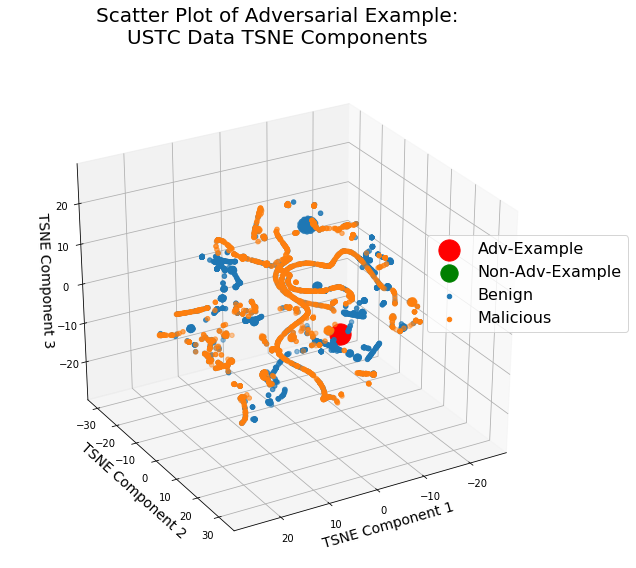

In [0]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
malicious_data_transformed = data_transformed[:NUM_SAMPLED]
benign_data_transformed = data_transformed[NUM_SAMPLED:NUM_SAMPLED+NUM_SAMPLED]
adv_example = data_transformed[NUM_SAMPLED+NUM_SAMPLED:NUM_SAMPLED+NUM_SAMPLED+1]
non_adv_example = data_transformed[NUM_SAMPLED+NUM_SAMPLED+1:]

BENIGN = {0: [x[0] for x in benign_data_transformed],
          1: [x[1] for x in benign_data_transformed],
         2: [x[2] for x in benign_data_transformed]}

MALICIOUS = {0: [x[0] for x in malicious_data_transformed],
          1: [x[1] for x in malicious_data_transformed],
         2: [x[2] for x in malicious_data_transformed]}

ADV_EXAMPLE = {0: [x[0] for x in adv_example],
          1: [x[1] for x in adv_example],
         2: [x[2] for x in adv_example]}

NON_ADV_EXAMPLE = {0: [x[0] for x in non_adv_example],
          1: [x[1] for x in non_adv_example],
         2: [x[2] for x in non_adv_example]}


from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(30, 60)
ax.figure.set_size_inches(10, 9)
_ = ax.scatter(ADV_EXAMPLE[0], ADV_EXAMPLE[1],ADV_EXAMPLE[2], marker='o',c='red',s=450, label="Adv-Example",zorder=2)
_ = ax.scatter(NON_ADV_EXAMPLE[0], NON_ADV_EXAMPLE[1],NON_ADV_EXAMPLE[2], marker='o',c='green',s=300, label="Non-Adv-Example",zorder=5)
_ = ax.scatter(BENIGN[0], BENIGN[1],BENIGN[2], label="Benign",zorder=0)
_ = ax.scatter(MALICIOUS[0], MALICIOUS[1],MALICIOUS[2], label="Malicious",zorder=1)
_ = fig.suptitle('Scatter Plot of Adversarial Example:\nUSTC Data TSNE Components', fontsize=20)
_ = ax.set_xlabel('TSNE Component 1')
_ = ax.set_ylabel('TSNE Component 2')
_ = ax.set_zlabel('TSNE Component 3')
ax.yaxis.label.set_size(14)
ax.xaxis.label.set_size(14)
ax.zaxis.label.set_size(14)
_ = fig.legend(loc='right',fontsize=16)

fig.savefig("./Figures/BASIC-USTC-adv-examplel1" +SCALE_STRING+".pdf", bbox_inches='tight')